<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="1000px"/> 

# TSO JWebbinar Notebook 1: Downloading and Calibrating `uncal` TSO Products
-----

**Author**: Néstor Espinoza, Mission Scientist for Exoplanet Science
<br>
**Last Updated**: November 27, 2023
<br>
**Pipeline Version**: 1.12.5

## Table of contents
1. [Introduction](#intro)<br>
   1.1 [Purpose of this Notebook](#purpose)<br>
   1.2 [Data & Context of the Observations](#data)<br>
2. [Downloading TSO data from MAST](#download)<br>
3. [A TSO tour through the `Detector1` stage](#detector1)<br>
   3.1 [Checking data quality flags](#dqflags)<br>
   3.2 [Identifying saturated pixels](#saturation)<br>
   3.3 [Removing detector-level effects: the `superbias` and `refpix` steps](#refpix)<br>
   3.4 [Linearity corrections](#linearity)<br>
   3.5 [Handling 1/f noise](#1overf)<br>
   3.6 [The "jump" detection](#jump)<br>
   3.7 [The ramp-fitting step](#rampfit)<br>
6. [Final words](#final-words)<br>

---

1.<font color='white'>-</font>Introduction <a class="anchor" id="intro"></a>
------------------

### 1.1<font color='white'>-</font>Purpose of this Notebook<a class="anchor" id="purpose"></a> ###

In this Notebook, we aim to perform an exploration of Time Series Observations (TSO) products, focusing in particular on products obtained by the [Transiting Exoplanet JWST Early Release Science (ERS) team](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1366) --- a real science dataset that we will reduce starting from the most "raw" forms of data products that can be downloaded from MAST. We will learn how to download those products, as well as how to load them and make them interact with the JWST Calibration Pipeline to calibrate them. In a companion Notebook, we then perform spectroscopic analyses on this dataset.

### 1.2<font color='white'>-</font>Data & Context of the Observations<a class="anchor" id="data"></a> ###

The input data for this Notebook are observations from the Transiting Exoplanet ERS team; in particular, observations of the exoplanet WASP-39b obtained with the JWST NIRSpec/G395H mode. This mode stores data in two detectors, NRS1 and NRS2 which hold data from about 3-4 $\mu$m and 4-5 $\mu$m, respectively. Results from those observations were presented in [Alderson et al. (2023)](https://www.nature.com/articles/s41586-022-05591-3), and consist of the transmission spectrum of the exoplanet in the 3-5 $\mu$m range. 

To get started, let's load some libraries that we will use in the following notebook:

In [1]:
# Need to set these enviromental variables for this notebook to work properly:
%set_env CRDS_PATH $HOME/crds_cache
%set_env CRDS_SERVER_URL https://jwst-crds.stsci.edu

# Import standard python libraries:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

# Import Observations from astroquery.mast to perform data downloads:
from astroquery.mast import Observations

# Import some JWST Calibration pipieline libraries we will use to load and calibrate our data:
import jwst
from jwst import datamodels
from jwst.pipeline import calwebb_detector1

env: CRDS_PATH=$HOME/crds_cache
env: CRDS_SERVER_URL=https://jwst-crds.stsci.edu


Check pipeline version we will be using:

In [2]:
jwst.__version__

'1.12.5'

2.<font color='white'>-</font>Downloading TSO data from MAST <a class="anchor" id="download"></a>
------------------

The very first step when it comes to analyzing a JWST dataset is to download that data. Here, we will download the `uncal` products, which are one of the "raw"est forms of dataproducts users can download from MAST. We will perform our data download using the `Observations` function from the `astroquery.mast` library which will allow us to access MAST directly from this notebook.

To do this, we need to indicate the properties of the dataset of interest. For this we need to figure out what instrument, filter, program ID _and_ target was obseved. Options for JWST TSO instruments are `NIRISS/SOSS`, `NIRSPEC/SLIT`, `NIRCAM/GRISM`, `MIRI/SLITLESS`, `NIRSPEC/SLIT`, etc. In particular, we here search for `NIRSpec/SLIT`, and the `F290LP;G395H` filter/grating combination, which corresponds to the dataset we want. We define the proposal ID for the ERS program (`1366`) and the name of the target, `WASP-39`:

In [23]:
observation = Observations.query_criteria(instrument_name = 'NIRSpec/SLIT', 
                                          filters='F290LP;G395H', 
                                          proposal_id = '1366', 
                                          target_name = 'WASP-39')

This saves _all_ possible observations in the `observation` variable. Then, we filter all the products to get only the `SCIENCE`, `UNCAL` data products:

In [25]:
# Get data products:
data_products = Observations.get_product_list(observation)

# Filter them to get ramps and rateints; only for the fourth segment of data:
uncals = Observations.filter_products(data_products, productType = 'SCIENCE', productSubGroupDescription = 'UNCAL')

Let's check these observations out:

In [27]:
uncals

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str4,str8,str54,str64,str1,str85,str9,str28,str13,str1,str7,str6,str4,str67,int64,str8,str6,int64
87768927,JWST,image,jw01366003001_02101_00001-seg001_nrs1,exposure (L1b): Uncalibrated 4D exposure data,S,mast:JWST/product/jw01366003001_02101_00001-seg001_nrs1_uncal.fits,SCIENCE,--,UNCAL,--,CALJWST,--,1366,jw01366003001_02101_00001-seg001_nrs1_uncal.fits,72000,87769481,PUBLIC,1
87768928,JWST,image,jw01366003001_02101_00002-seg001_nrs1,exposure (L1b): Uncalibrated 4D exposure data,S,mast:JWST/product/jw01366003001_02101_00002-seg001_nrs1_uncal.fits,SCIENCE,--,UNCAL,--,CALJWST,--,1366,jw01366003001_02101_00002-seg001_nrs1_uncal.fits,60480,87769481,PUBLIC,1
87769343,JWST,image,jw01366003001_04101_00001-seg001_nrs1,exposure (L1b): Uncalibrated 4D exposure data,S,mast:JWST/product/jw01366003001_04101_00001-seg001_nrs1_uncal.fits,SCIENCE,--,UNCAL,--,CALJWST,--,1366,jw01366003001_04101_00001-seg001_nrs1_uncal.fits,1422201600,87769481,PUBLIC,1
87769340,JWST,image,jw01366003001_04101_00001-seg001_nrs2,exposure (L1b): Uncalibrated 4D exposure data,S,mast:JWST/product/jw01366003001_04101_00001-seg001_nrs2_uncal.fits,SCIENCE,--,UNCAL,--,CALJWST,--,1366,jw01366003001_04101_00001-seg001_nrs2_uncal.fits,1422201600,87769481,PUBLIC,1
87769345,JWST,image,jw01366003001_04101_00001-seg002_nrs1,exposure (L1b): Uncalibrated 4D exposure data,S,mast:JWST/product/jw01366003001_04101_00001-seg002_nrs1_uncal.fits,SCIENCE,--,UNCAL,--,CALJWST,--,1366,jw01366003001_04101_00001-seg002_nrs1_uncal.fits,1422201600,87769481,PUBLIC,1
87769342,JWST,image,jw01366003001_04101_00001-seg002_nrs2,exposure (L1b): Uncalibrated 4D exposure data,S,mast:JWST/product/jw01366003001_04101_00001-seg002_nrs2_uncal.fits,SCIENCE,--,UNCAL,--,CALJWST,--,1366,jw01366003001_04101_00001-seg002_nrs2_uncal.fits,1422201600,87769481,PUBLIC,1
87769341,JWST,image,jw01366003001_04101_00001-seg003_nrs1,exposure (L1b): Uncalibrated 4D exposure data,S,mast:JWST/product/jw01366003001_04101_00001-seg003_nrs1_uncal.fits,SCIENCE,--,UNCAL,--,CALJWST,--,1366,jw01366003001_04101_00001-seg003_nrs1_uncal.fits,1422201600,87769481,PUBLIC,1
87769344,JWST,image,jw01366003001_04101_00001-seg003_nrs2,exposure (L1b): Uncalibrated 4D exposure data,S,mast:JWST/product/jw01366003001_04101_00001-seg003_nrs2_uncal.fits,SCIENCE,--,UNCAL,--,CALJWST,--,1366,jw01366003001_04101_00001-seg003_nrs2_uncal.fits,1422201600,87769481,PUBLIC,1


Note how there are 8 data products. The first 2, which have the lowest `size` values are the Target Aquisition exposures, used to lock the data into place. These are _very_ useful to check the quality of the observations (and whether or not they were successful!). The _actual_ TSO data are all the products that follow. Note the latter data are segmented --- this is done in the ground to facilitate the processing of the data. Also note, for the TSO products, there are 3 segments of data per detector (`nrs1` and `nrs2`).

Let's download all the data, including the Target Acquisition frames, which might be useful to diagnose the quality of observations:

In [31]:
Observations.download_products(uncals)

Local Path,Status,Message,URL
str106,str8,object,object
./mastDownload/JWST/jw01366003001_02101_00001-seg001_nrs1/jw01366003001_02101_00001-seg001_nrs1_uncal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01366003001_02101_00002-seg001_nrs1/jw01366003001_02101_00002-seg001_nrs1_uncal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01366003001_04101_00001-seg001_nrs1/jw01366003001_04101_00001-seg001_nrs1_uncal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01366003001_04101_00001-seg001_nrs2/jw01366003001_04101_00001-seg001_nrs2_uncal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01366003001_04101_00001-seg002_nrs1/jw01366003001_04101_00001-seg002_nrs1_uncal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01366003001_04101_00001-seg002_nrs2/jw01366003001_04101_00001-seg002_nrs2_uncal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01366003001_04101_00001-seg003_nrs1/jw01366003001_04101_00001-seg003_nrs1_uncal.fits,COMPLETE,None,None
./mastDownload/JWST/jw01366003001_04101_00001-seg003_nrs2/jw01366003001_04101_00001-seg003_nrs2_uncal.fits,COMPLETE,None,None


Great, all downloads are complete! 

Next up, we will load those data products so we can interact with them below. To this end, we open those using the JWST `datamodels` --- this is the basis around which we interact with JWST products. There's many models we can use within those `datamodels`; here we will use the `datamodels.RampModel` to load those `uncal` products, which handle up-the-ramp samples such as the ones present in those products:

In [3]:
uncal_nrs1 = [datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg001_nrs1/jw01366003001_04101_00001-seg001_nrs1_uncal.fits'),
              datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg002_nrs1/jw01366003001_04101_00001-seg002_nrs1_uncal.fits'),
              datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg003_nrs1/jw01366003001_04101_00001-seg003_nrs1_uncal.fits')]

uncal_nrs2 = [datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg001_nrs2/jw01366003001_04101_00001-seg001_nrs2_uncal.fits'),
              datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg002_nrs2/jw01366003001_04101_00001-seg002_nrs2_uncal.fits'),
              datamodels.RampModel('mastDownload/JWST/jw01366003001_04101_00001-seg003_nrs2/jw01366003001_04101_00001-seg003_nrs2_uncal.fits')]

Note how we load each segment of data for each detector in simple python `list`s! This is the simplicity that these `datamodels` offer --- we'll take advantage of that below when we explore the data products in detail.

<div class="alert alert-block alert-info"> <b>Note on memory usage</b>: Loading data products in lists is very useful, but be aware that in particular for TSOs --- which typically involve large data volumes --- Random-Access Memory (RAM) might be severely impacted. The above loaded data products, for instance, take of order ~8 GB --- and this will only be larger as we run pipeline steps below, which convert data products from, e.g., ints to floats, taking even more space. For a typical TSO, when running the pipeline steps we'll run below, consider on the order of ~50 GB will be used.</div>

3.<font color='white'>-</font>A TSO tour through the `Detector1` stage <a class="anchor" id="setup"></a>
------------------

The `uncal` data products we loaded above contain a series of detector systematic effects that we need to remove before our data is ready for science. Now, we will move to calibrating those TSO `uncal` data products, which will take care of most of those effects. To perform this calibration, here we will follow most of the steps outlined in the `calwebb_detector1` or "Stage 1" processing described in the [JWST Calibration pipeline documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html). This Stage 1 processing is defined by a series of steps --- some of which we will slightly modify to suit our TSO needs. 

### 3.1<font color='white'>-</font>Checking data quality flags <a class="anchor" id="dqflags"></a>

An important component of any TSO analysis is to flag bad pixels, pixels identified as cosmic rays and/or identify saturated pixels. Bad pixels are, in fact, curated by the instrument teams in what we colloquially refer to as a "bad pixel mask" --- a mask one can "attach" to the data products with the JWST Calibration pipeline. This is exactly what the first step in the pipeline, the `dq_init` step, does. 

#### 3.1.1 Running & understanding the `dq_init` step

Let's run the `dq_init` step on the first segment of our data products for NRS1 and NRS2: 

In [4]:
# Let's run the DQ init step; first for the first segment of the NRS1 detector:
print('Running dq_init on NRS1:')
nrs1_seg1_dqinit = calwebb_detector1.dq_init_step.DQInitStep.call(uncal_nrs1[0])

# Now, same on the NRS2 detector:
print('Running dq_init on NRS2:')
nrs2_seg1_dqinit = calwebb_detector1.dq_init_step.DQInitStep.call(uncal_nrs2[0])

Running dq_init on NRS1:


2023-11-25 10:17:17,845 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-11-25 10:17:18,917 - stpipe.DQInitStep - INFO - Step DQInitStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-11-25 10:17:18,917 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-11-25 10:17:18,933 - stpipe.DQInitStep - INFO - Using MASK reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits
2023-11-25 10:17:31,897 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2023-11-25 10:17:33,512 - stpipe.DQInitStep - INFO - Results used CRDS context: jwst_1149.pmap
2023-11-25 10:17:33,513 - stpipe.DQInitStep - INFO - Step DQIn

Running dq_init on NRS2:


2023-11-25 10:17:39,255 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2023-11-25 10:17:41,084 - stpipe.DQInitStep - INFO - Results used CRDS context: jwst_1149.pmap
2023-11-25 10:17:41,085 - stpipe.DQInitStep - INFO - Step DQInitStep done


All right, data-quality flags have been attached to our uncalibrated data products. To figure out why these are so useful, let's take a look at this bad pixel mask that was attached to our data products; in particular, let's peek at the one attached to the NRS1 detector products. This mask lives in the `pixeldq` attribute of our products (e.g., `nrs1_seg1_dqinit.pixeldq`). To familiarize ourselves with this, let's print the dimensions of this mask:

In [5]:
nrs1_seg1_dqinit.pixeldq.shape

(32, 2048)

As expected, it has the same size as our subarray. [As per the documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html?highlight=data%20quality%20flags#data-quality-flags), most data-quality (DQ) flags should be zero in the subarray; let's plot this array to see how many of them get away from this value and where:

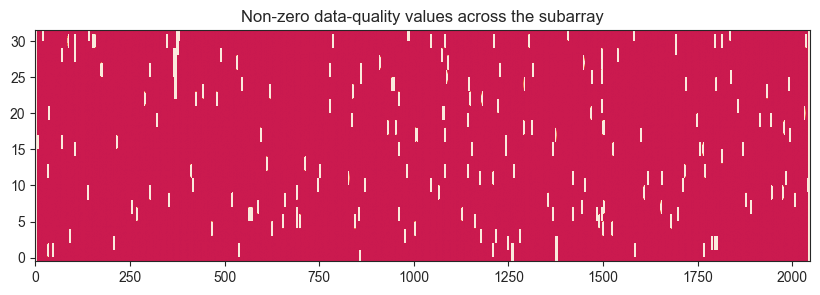

In [6]:
plt.figure(figsize=(10,3))

plt.title('Non-zero data-quality values across the subarray')
im = plt.imshow(nrs1_seg1_dqinit.pixeldq, aspect = 'auto', origin = 'lower')
im.set_clim(-0.5,0.5)

Let's plot now a random integration and group from the data itself; this is stored in the `data` attribute of our products (e.g., `nrs1_seg1_dqinit.data`). To familiarize ourselves with how to interact with this, let's first print the dimensions of the `data` attribute that holds this information:

In [7]:
nrs1_seg1_dqinit.data.shape

(155, 70, 32, 2048)

The format of the dimensions are `(integrations, groups, row pixels, column pixels)` --- let's take a look at the products of the 10th integration, last group:

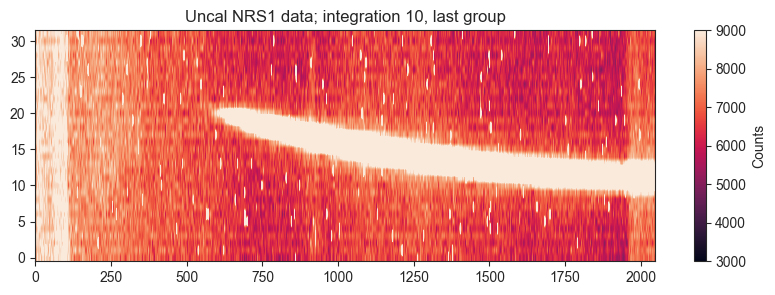

In [92]:
plt.figure(figsize=(10,3))

plt.title('Uncal NRS1 data; integration 10, last group')
im = plt.imshow(nrs1_seg1_dqinit.data[10, -1, :, :], aspect = 'auto', origin = 'lower')
im.set_clim(3000,9000)

plt.colorbar(label = 'Counts')

In this latter figure the central, sword-like feature running from pixel column about 600 all the way through column 2044 is the actual spectrum of WASP-39; everything else is mostly detector effects. Note that the series of "bright" pixels scattered around this frame are pretty much at the same locations as the bad pixels identified by the pipeline. 

But, what are the `pixeldq` values telling us? Let's print the pixel in the very corner of the subarray:

In [9]:
nrs1_seg1_dqinit.pixeldq[0,0]

2147483648

[According to the documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html?highlight=data%20quality%20flags#data-quality-flags), this pixel is a **reference pixel**. This makes sense: for NRS1 and NRS2 in this NIRSpec/G395H mode, the 4 pixel columns on the left-most end and the 4 pixel columns on the right-most end are indeed, reference pixels.

#### 3.1.2 Dynamically translating data-quality flags to human-readable form

Looking back and forth from the documentation page the data-quality flag values we read from our data-products is a very tedious task. In addition, as we will see below, a pixel can have eventually several flags (e.g., saturated, has a cosmic-ray, etc.) which will, in turn, change some of its data-quality flags to account for this. 

A handy function to convert those data-quality flag numbers to "human-readable" form is actually inside the `datamodels` class --- the `datamodels.dqflags`. This simply takes in a data-quality value, and spits out a `set` with strings defining what this is telling us given a so-called "mnemonic map" --- one which is actually already loaded in the `datamodels.dqflags.pixel` dictionary.

Let's try it out on the data-quality value we observed above:

In [10]:
datamodels.dqflags.dqflags_to_mnemonics(2147483648, mnemonic_map = datamodels.dqflags.pixel)

{'REFERENCE_PIXEL'}

Indeed, we get back what we knew --- that is a reference pixel! With this handy-dandy function, we can write a simple snippet to figure out the total tally of all bad pixels as follows:

In [11]:
# Create a dictionary that will save all types of bad pixels:
bad_pixels = {}

rows, columns = nrs1_seg1_dqinit.pixeldq.shape

# Iterate through every row and column:
for row in range(rows):
    
    for column in range(columns):

        # Extract the bad pixel flag(s) for the current pixel at (row, column):
        bps = datamodels.dqflags.dqflags_to_mnemonics(nrs1_seg1_dqinit.pixeldq[row, column], 
                                                     mnemonic_map = datamodels.dqflags.pixel)

        # Iterate through the possible flags (it can be more than one!):
        for bp in bps:

            # If already in the bad_pixels dict, simply add 1 to the counter. If not, create and instantiate to one:
            if bp in bad_pixels.keys():

                bad_pixels[bp] += 1

            else:

                bad_pixels[bp] = 1

# Now print total tally:
total_pixels = rows * columns

print('From a total of ',total_pixels,' pixels, the "bad-pixel" tally is as follows:\n')
for bp in list( bad_pixels.keys() ):

    print('-> ',bad_pixels[bp], 
          'pixels marked as '+bp, 
          '({0:.2f}% of pixels)'.format(100*(bad_pixels[bp]/float(total_pixels))))

From a total of  65536  pixels, the "bad-pixel" tally is as follows:

->  256 pixels marked as REFERENCE_PIXEL (0.39% of pixels)
->  251 pixels marked as DO_NOT_USE (0.38% of pixels)
->  78 pixels marked as HOT (0.12% of pixels)
->  44 pixels marked as ADJ_OPEN (0.07% of pixels)
->  7 pixels marked as OPEN (0.01% of pixels)
->  112 pixels marked as DEAD (0.17% of pixels)
->  25 pixels marked as LOW_QE (0.04% of pixels)


Based on our discussion above, we can see some numbers above make sense. For instance, 256 `REFERENCE_PIXELS` make sense as there are a total of 8 columns (4 to the left, 4 to the right of the subarray) with reference pixels --- given the subarray height is 32 pixels, this gives a total of 256 reference pixels as expected.

Let's go ahead now and attach this bad pixel mask to all the segments of data, for both NRS1 and NRS2:

In [12]:
nsegments = 3
for i in range(nsegments):

    uncal_nrs1[i] = calwebb_detector1.dq_init_step.DQInitStep.call(uncal_nrs1[i])
    uncal_nrs2[i] = calwebb_detector1.dq_init_step.DQInitStep.call(uncal_nrs2[i])

2023-11-25 10:17:43,396 - stpipe.DQInitStep - INFO - DQInitStep instance created.
2023-11-25 10:17:43,471 - stpipe.DQInitStep - INFO - Step DQInitStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-11-25 10:17:43,472 - stpipe.DQInitStep - INFO - Step DQInitStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-11-25 10:17:43,488 - stpipe.DQInitStep - INFO - Using MASK reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0051.fits
2023-11-25 10:17:46,536 - stpipe.DQInitStep - INFO - Extracting mask subarray to match science data
2023-11-25 10:17:48,614 - stpipe.DQInitStep - INFO - Results used CRDS context: jwst_1149.pmap
2023-11-25 10:17:48,615 - stpipe.DQInitStep - INFO - Step DQIn

<div class="alert alert-block alert-info"> <b>Note on saving data products with the JWST Calibration Pipeline</b>: Sometimes, one might find it useful to save data products after running each step into <code>.fits</code> files, so we can have "intermediate steps" stored in our system that we can check at a later time. This can be done when running any of the steps by adding the <code>save_results = True</code> flag to the step calls, e.g., <code>calwebb_detector1.dq_init_step.DQInitStep.call(uncal_nrs1[i], save_results = True)</code>. An output directory can also be defined by using the <code>output_dir</code> parameter.

### 3.2<font color='white'>-</font>Identifying saturated pixels <a class="anchor" id="saturation"></a>


One very important detail in JWST data analysis involves checking which pixels are "saturated" or not. Saturation in the JWST context is an [instrument-by-instrument defined upper signal level](https://jwst-docs.stsci.edu/methods-and-roadmaps/jwst-time-series-observations/jwst-time-series-observations-tso-saturation), typically defined as a limit above which detector effects not modeled by the pipeline might start to kick-in. As such, identifying which pixels are above this limit is important. In particular, the pipeline uses tends to omit those pixels from analyses, as they might introduce unwanted systematic effects.

#### 3.2.1 Running and understanding the `saturation` step

Through the analysis of calibration datasets, the JWST instrument teams have defined signal values for each pixel above which they are considered as "saturated". This identification is done through the `saturation` step --- the next step of the JWST pipeline for Detector 1. Let's run it for the very first segment of data for NRS1:

In [13]:
# Run saturation step:
saturation_results = calwebb_detector1.saturation_step.SaturationStep.call(uncal_nrs1[0])

2023-11-25 10:18:52,472 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2023-11-25 10:18:52,558 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-11-25 10:18:52,560 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}
2023-11-25 10:18:52,578 - stpipe.SaturationStep - INFO - Using SATURATION reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits
2023-11-25 10:19:05,133 - stpipe.SaturationStep - INFO - Extracting reference file subarray to match science data
2023-11-25 10:19:20,307 - stpipe.SaturationStep - INFO - Detected 789 saturated pi

The saturation step works by primarily comparing the observed count values with the saturation signal-levels defined for each pixel in a reference file. As can be seen above, that reference file is indicated by the line `stpipe.SaturationStep - INFO - Using SATURATION reference file [yourfile]`. In the case of our run at the time of writing, this was the `jwst_niriss_saturation_0028.fits ` file --- but this might change as new analyses are made and the reference files get updated. 

In addition, at the time of writing, the `saturation` step in the JWST Calibration pipeline by default flags not only pixels that exceed the signal limit defined by the instrument teams but also all `n_pix_grow_sat` pixels around it; which at the time of writing is set to a default of `1`. That means that if a given pixel exceeds the signal limit, all 8 pixels around it will be marked as saturated as well. This is done because it has been observed that "charge spilling" can be an issue --- i.e., charge going from one pixel to another. While such migration of charge happens at a wide range of count levels, this is particularly dramatic when a pixel saturates --- reason by which this is set in the pipeline.

We can check which pixels are saturated in a similar way as to how we checked the data-quality flags in [Section 3.1](#dqflags). The only difference with that analysis is that saturated pixels are integration and group-dependant, i.e., a property of a given pixel _in a given integration and group_. In other words, a pixel that is saturated in one integration and group might have "recovered" by the next integration and group.

To figure out the data-quality for all integrations and all groups we look at the `groupdq` attribute of our data products instead of the `pixeldq` which we used above. To familiarize ourselves with this, let's print the dimensions of this array first:

In [14]:
saturation_results.groupdq.shape

(155, 70, 32, 2048)

As expected, it has dimensions `(integrations, groups, row pixels, column pixels)`, just like the `data` array. The flags in the `groupdq` array follow the same structure as [all the data-quality flags described in the documentation](https://jwst-pipeline.readthedocs.io/en/latest/jwst/references_general/references_general.html?highlight=data%20quality%20flags#data-quality-flags). 

#### 3.2.2 Exploring saturated pixels via the `groupdq` array

To illustrate how to use the `groupdq`, let's pick the last group of integration 10 again and see if any pixels seem to be saturated --- we also count all of the saturated pixels:

In [15]:
# Iterate through every row and column of integration number 10, last group:
integration, group = 10, -1
nsaturated = 0
for row in range(rows):
    
    for column in range(columns):

        # Extract the bad pixel flag(s) for the current pixel at (row, column):
        bps = datamodels.dqflags.dqflags_to_mnemonics(saturation_results.groupdq[integration, group, row, column], 
                                                      mnemonic_map = datamodels.dqflags.pixel)
        
        # Check if pixel is saturated; if it is...
        if 'SATURATED' in bps:

            # ...print which pixel it is, and...
            print('Pixel ({0:},{1:}) is saturated in integration 10, last group'.format(row, column))

            # ...count it:
            nsaturated += 1

print('\nA total of {0:} out of {1:} pixels ({2:.2f}%) are saturated'.format(nsaturated, 
                                                                             rows*columns, 
                                                                             100 * nsaturated / float(rows * columns)
                                                                            )
     )

Pixel (2,99) is saturated in integration 10, last group
Pixel (2,100) is saturated in integration 10, last group
Pixel (2,101) is saturated in integration 10, last group
Pixel (3,99) is saturated in integration 10, last group
Pixel (3,100) is saturated in integration 10, last group
Pixel (3,101) is saturated in integration 10, last group
Pixel (4,99) is saturated in integration 10, last group
Pixel (4,100) is saturated in integration 10, last group
Pixel (4,101) is saturated in integration 10, last group
Pixel (4,844) is saturated in integration 10, last group
Pixel (4,845) is saturated in integration 10, last group
Pixel (4,846) is saturated in integration 10, last group
Pixel (5,844) is saturated in integration 10, last group
Pixel (5,845) is saturated in integration 10, last group
Pixel (5,846) is saturated in integration 10, last group
Pixel (6,844) is saturated in integration 10, last group
Pixel (6,845) is saturated in integration 10, last group
Pixel (6,846) is saturated in inte

As can be seen, not many pixels are saturated on a given group. Let's see how the up-the-ramp samples look like for one of those pixels --- let's say, pixel `(3, 100)`. Let's show in the same plot the group data-quality flags at each group:

Text(0, 0.5, 'Group Data-quality')

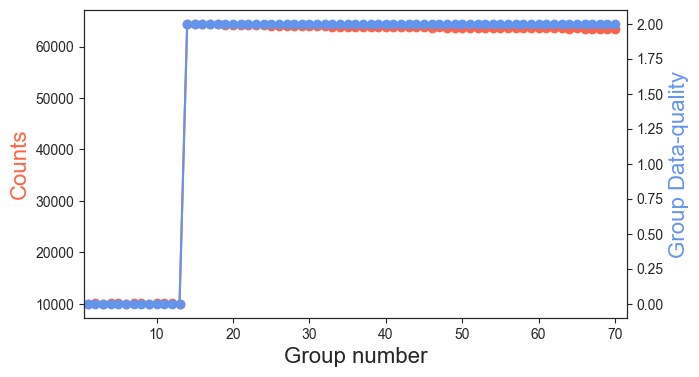

In [64]:
pixel_row, pixel_column = 3, 100

plt.figure(figsize=(7,4))

plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.data[integration, :, pixel_row, pixel_column], 
         'o-', color = 'tomato')

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16, color = 'tomato')

plt.twinx()

plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.groupdq[integration, :, pixel_row, pixel_column], 
         'o-', color = 'cornflowerblue')

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.ylabel('Group Data-quality', fontsize = 16, color = 'cornflowerblue')

Very interesting plot! Note that all groups appear to be saturated after group ~13. Likely a cosmic-ray hit happened at this group which left the pixel at a very high count number from group 14 up to the end of the ramp.

#### 3.2.3 Setting custom saturation limits with the `saturation` reference file

TSOs often obtain data from bright stars that might quickly (i.e., first few groups) give rise to saturated pixels. As described in some early JWST results (see, e.g., [Rustamkulov et al., 2023](https://www.nature.com/articles/s41586-022-05677-y)), in some cases one might even want to be a bit more aggressive on the level of saturation allowed in a given dataset in order to improve on the reliability of the results. As such, understanding how to modify the level of saturation allowed in a given dataset might turn out to be an important skill on real TSO data analysis. 

The key file that defines the limits defined to call a pixel "saturated" is the reference file of the `saturation` step. As discussed above, this can be seen directly on the outputs of the `saturation` step while its running, but it's also saved in our data products:

In [44]:
saturation_results.meta.ref_file.saturation.name

'crds://jwst_nirspec_saturation_0028.fits'

We can actually load this reference file using the `SaturationModel` as follows:

In [45]:
# Base directory where reference files are stored (this was defined in the Setup section above):
base_ref_files = '$HOME/crds_cache/references/jwst/nirspec/'

# Read it in:
saturation_ref_file = datamodels.SaturationModel(base_ref_files+saturation_results.meta.ref_file.saturation.name[7:])

More often than not, however, the saturation reference file might not match exactly the dimensions of our subarray. This is because the reference file might be padded to match several other subarrays, and thus we have to figure out how to "cut" it to match our data. This is, in fact, our case:

In [46]:
saturation_ref_file.data.shape

(260, 2048)

Luckily, the JWST calibration pipeline has a handy function to transform the dimensions between instruments --- this is the `jwst.lib.reffile_utils.get_subarray_model` function, which recieves an input data model (e.g., the one from our data) along with the reference file, and spits out the same reference file model but with the right dimensions. Let's use it:

In [48]:
tailored_saturation_ref_file = jwst.lib.reffile_utils.get_subarray_model(saturation_results, saturation_ref_file)

Indeed, now our "tailored" reference file matches our science data dimensions:

In [50]:
tailored_saturation_ref_file.data.shape

(32, 2048)

Let's see how the saturation map looks like for our subarray:

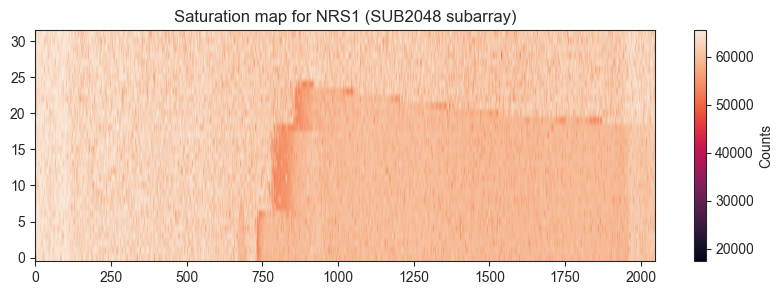

In [90]:
plt.figure(figsize=(10,3))

plt.title('Saturation map for NRS1 (SUB2048 subarray)')
im = plt.imshow(tailored_saturation_ref_file.data, aspect = 'auto', origin = 'lower', interpolation = None)

plt.colorbar(label = 'Counts')

There's clearly some structure, albeit is not exactly clear what values different pixels take. To visualize this, let's print the saturation limit for pixel `(3,100)`, the one we explored above:

In [65]:
tailored_saturation_ref_file.data[pixel_row, pixel_column]

61564.0

If the counts surpass this limit, the pixel will be considered saturated. To see if this was the case, let's repeat the plot above marking this signal limit:

Text(0, 0.5, 'Group Data-quality')

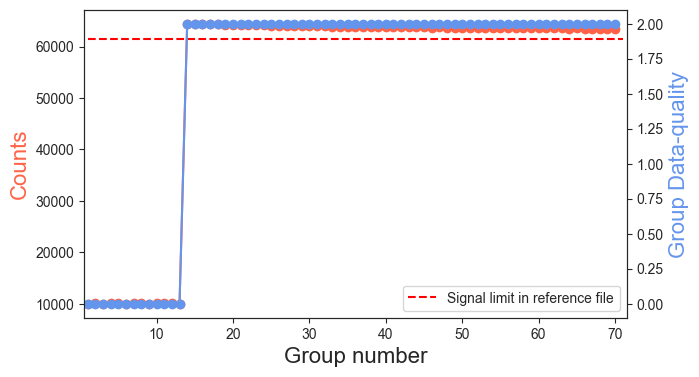

In [67]:
pixel_row, pixel_column = 3, 100

plt.figure(figsize=(7,4))

plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.data[integration, :, pixel_row, pixel_column], 
         'o-', color = 'tomato')

plt.plot([1, saturation_results.data.shape[1]+1], 
         [tailored_saturation_ref_file.data[pixel_row, pixel_column], 
          tailored_saturation_ref_file.data[pixel_row, pixel_column]],
         'r--', 
         label = 'Signal limit in reference file'
        )

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16, color = 'tomato')
plt.legend()

plt.twinx()

plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.groupdq[integration, :, pixel_row, pixel_column], 
         'o-', color = 'cornflowerblue')

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.ylabel('Group Data-quality', fontsize = 16, color = 'cornflowerblue')

Indeed, this is the case! Note that, as described above, by default for NIRSpec not only this pixel gets marked as saturated, but all pixels around it. To see this, note for instance the same plot as above but for pixel (2,99):

Text(0, 0.5, 'Group Data-quality')

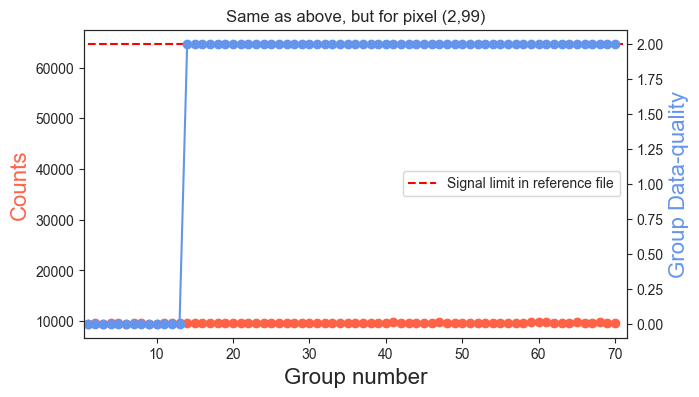

In [129]:
pixel_row, pixel_column = 2, 99

plt.figure(figsize=(7,4))

plt.title('Same as above, but for pixel (2,99)')
plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.data[integration, :, pixel_row, pixel_column], 
         'o-', color = 'tomato')

plt.plot([1, saturation_results.data.shape[1]+1], 
         [tailored_saturation_ref_file.data[pixel_row, pixel_column], 
          tailored_saturation_ref_file.data[pixel_row, pixel_column]],
         'r--', 
         label = 'Signal limit in reference file'
        )

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16, color = 'tomato')
plt.legend()

plt.twinx()

plt.plot(np.arange(saturation_results.data.shape[1])+1, 
         saturation_results.groupdq[integration, :, pixel_row, pixel_column], 
         'o-', color = 'cornflowerblue')

plt.xlim(0.5, saturation_results.data.shape[1]+1.5)
plt.ylabel('Group Data-quality', fontsize = 16, color = 'cornflowerblue')

Note how the signal level has not gone above the limit in the reference file, but it is marked as saturated because pixel (3,100) is. Again, this is to account for possible charge spilling to the pixel.

Now, what if we wanted to mark as saturated all pixels, say, larger than 50\% these saturation values? Well, we can directly modify the reference file and repeat the calculation pointing at it:

In [68]:
saturation_ref_file.data = saturation_ref_file.data * 0.5

To incorporate this new reference file, we simply use the `override_saturation` flag, passing this new `SaturationModel` along: 

In [69]:
# Run saturation step:
saturation_results2 = calwebb_detector1.saturation_step.SaturationStep.call(uncal_nrs1[0], 
                                                                            override_saturation = saturation_ref_file)

2023-11-25 23:33:06,323 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2023-11-25 23:33:06,414 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-11-25 23:33:06,414 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}
2023-11-25 23:33:06,422 - stpipe.SaturationStep - INFO - Using SATURATION reference file <SaturationModel(260, 2048) from jwst_nirspec_saturation_0028.fits>
2023-11-25 23:33:18,802 - stpipe.SaturationStep - INFO - Extracting reference file subarray to match science data
2023-11-25 23:33:34,183 - stpipe.SaturationStep - INFO - Detected 7772 saturated pixels
2

Let's see how many pixels are now counted as saturated:

In [71]:
# Iterate through every row and column of integration number 10, last group:
integration, group = 10, -1
nsaturated = 0
for row in range(rows):
    
    for column in range(columns):

        # Extract the bad pixel flag(s) for the current pixel at (row, column):
        bps = datamodels.dqflags.dqflags_to_mnemonics(saturation_results2.groupdq[integration, group, row, column], 
                                                      mnemonic_map = datamodels.dqflags.pixel)
        
        # Check if pixel is saturated; if it is...
        if 'SATURATED' in bps:

            # ...print which pixel it is, and...
            print('Pixel ({0:},{1:}) is saturated in integration 10, last group'.format(row, column))

            # ...count it:
            nsaturated += 1

print('\nA total of {0:} out of {1:} pixels ({2:.2f}%) are saturated'.format(nsaturated, 
                                                                             rows*columns, 
                                                                             100 * nsaturated / float(rows * columns)
                                                                            )
     )

Pixel (0,34) is saturated in integration 10, last group
Pixel (0,35) is saturated in integration 10, last group
Pixel (0,36) is saturated in integration 10, last group
Pixel (0,1362) is saturated in integration 10, last group
Pixel (0,1363) is saturated in integration 10, last group
Pixel (0,1364) is saturated in integration 10, last group
Pixel (1,34) is saturated in integration 10, last group
Pixel (1,35) is saturated in integration 10, last group
Pixel (1,36) is saturated in integration 10, last group
Pixel (1,1362) is saturated in integration 10, last group
Pixel (1,1363) is saturated in integration 10, last group
Pixel (1,1364) is saturated in integration 10, last group
Pixel (2,34) is saturated in integration 10, last group
Pixel (2,35) is saturated in integration 10, last group
Pixel (2,36) is saturated in integration 10, last group
Pixel (2,91) is saturated in integration 10, last group
Pixel (2,92) is saturated in integration 10, last group
Pixel (2,93) is saturated in integra

As expected, a much bigger portion! About 5\% of the pixels in the subarray are now masked (against 0.04\% from before) as saturated thanks to our higher threshold for flagging.

Before moving to the next step, let's run the saturation step on both NRS1 and NRS2:

In [80]:
nsegments = 3
for i in range(nsegments):

    uncal_nrs1[i] = calwebb_detector1.saturation_step.SaturationStep.call(uncal_nrs1[i])
    uncal_nrs2[i] = calwebb_detector1.saturation_step.SaturationStep.call(uncal_nrs2[i])

2023-11-26 03:25:48,332 - stpipe.SaturationStep - INFO - SaturationStep instance created.
2023-11-26 03:25:48,498 - stpipe.SaturationStep - INFO - Step SaturationStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-11-26 03:25:48,499 - stpipe.SaturationStep - INFO - Step SaturationStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}
2023-11-26 03:25:48,515 - stpipe.SaturationStep - INFO - Using SATURATION reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0028.fits
2023-11-26 03:25:52,735 - stpipe.SaturationStep - INFO - Extracting reference file subarray to match science data
2023-11-26 03:26:07,652 - stpipe.SaturationStep - INFO - Detected 789 saturated pi

### 3.3<font color='white'>-</font>Removing detector-level effects: the `superbias` and `refpix` steps <a class="anchor" id="refpix"></a>

So far, we have focused on flagging pixels for various effects (e.g., bad pixels, saturation) but we haven't worked directly with the actual counts on our data. In this Section, we deal with various (non-astrophysical) detector-level effects present in our data through two steps in the JWST Calibration pipeline: the `superbias` and the `refpix` steps. 

#### 3.3.1 Removing the pedestal from the detector: the `superbias` step

All detectors have mostly stable, factory-defined pedestal levels, which can be closely monitored with the right calibration exposures. Indeed, instrument teams closely monitor and refine this via what is called the "super" bias --- the spatial shape of this pedestal. The JWST Calibration pipeline substracts this pedestal from data via the `superbias` step.

Applying this correction to the data is very simple to do; let's apply it once again to the first segment of data for the NRS1 detector, so we can check how our data changes after applying the step:

In [82]:
superbias_results = calwebb_detector1.superbias_step.SuperBiasStep.call(uncal_nrs1[i])

2023-11-26 23:26:31,984 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2023-11-26 23:26:32,111 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).
2023-11-26 23:26:32,112 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-11-26 23:26:32,129 - CRDS - INFO -  Fetching  $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits  815.0 K bytes  (1 / 1 files) (0 / 815.0 K bytes)
2023-11-26 23:26:32,733 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits
2023-11-26 23:26:39,270 - stpipe.SuperBiasStep - IN

Once again, we can see that there is a particular reference file being used to remove the pedestal, `jwst_nirspec_superbias_0427.fits`, which can be explored in a similar way as how we explored the reference file for the `saturation` step above. Let's see how our data changed after applying this pedestal removal --- let's again take the last group of integration 10 as an example:

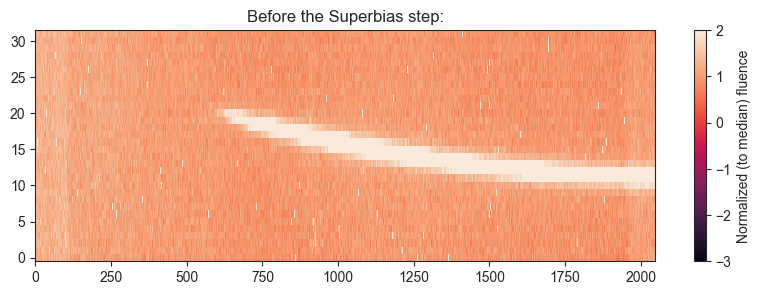

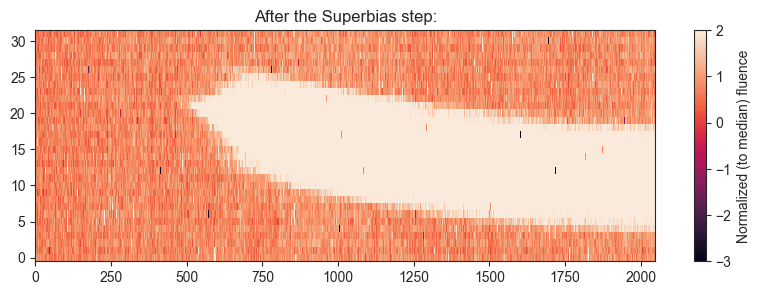

In [89]:
# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(uncal_nrs1[0].data[10,-1,:,:] / np.nanmedian(uncal_nrs1[0].data[10,-1,:,:]), \
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-3,2)
plt.title('Before the Superbias step:')

plt.colorbar(label = 'Normalized (to median) fluence')

# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(superbias_results.data[10,-1,:,:] / np.nanmedian(superbias_results.data[10,-1,:,:]), \
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-3,2)
plt.title('After the Superbias step:')
plt.colorbar(label = 'Normalized (to median) fluence')

Wow! That's a huge change. Overall, this looks much better. Let's plot the profiles of pixel column index 1500 to have a closer look:

Text(0, 0.5, 'Counts - Median Counts')

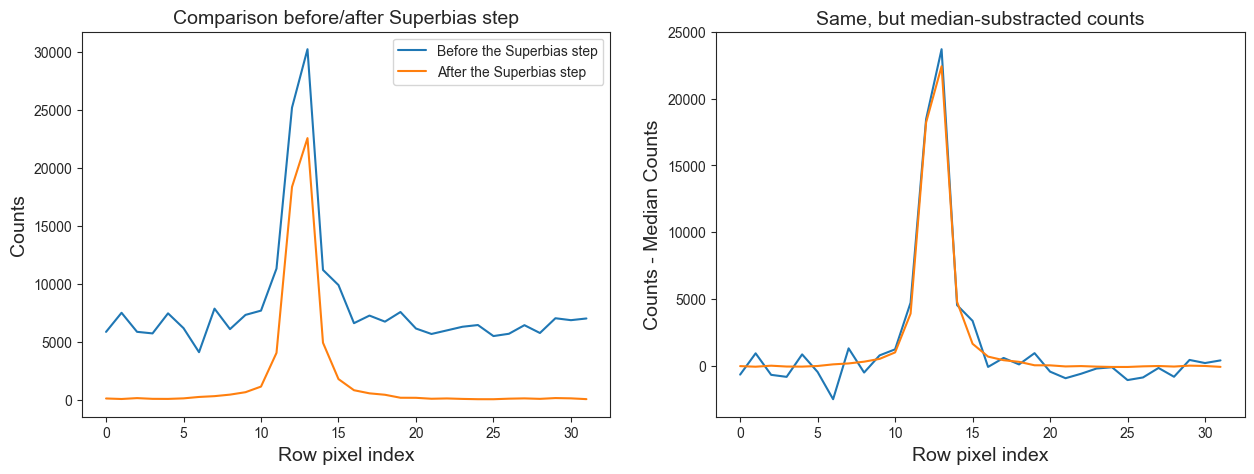

In [93]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(uncal_nrs1[0].data[10,-1,:,1500], label = 'Before the Superbias step')
ax[0].plot(superbias_results.data[0,-1,:,1500], label = 'After the Superbias step')
ax[0].set_xlabel('Row pixel index', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_title('Comparison before/after Superbias step', fontsize = 14)
ax[0].legend()

ax[1].set_title('Same, but median-substracted counts', fontsize = 14)
ax[1].plot(uncal_nrs1[0].data[0,-1,:,1500] - np.nanmedian(uncal_nrs1[0].data[0,-1,:,1500]))
ax[1].plot(superbias_results.data[0,-1,:,1500] - np.nanmedian(superbias_results.data[0,-1,:,1500]))
ax[1].set_xlabel('Row pixel index', fontsize = 14)
ax[1].set_ylabel('Counts - Median Counts', fontsize = 14)

As can be seen, a ton of structure has been removed. Also, all the pixels seem to be at the same background level. This is a good sign that the Superbias correction has worked, in principle, correctly. 

However, if we take a more detailed look at background pixels, we can note an interesting pattern. Let's plot a similar cut to the one above, but for column 250 --- which is far away from any illuminted pixels in the detector. Let's also plot the last superbias-corrected group and the second-to-last superbias-corrected group:

Text(0, 0.5, 'Counts')

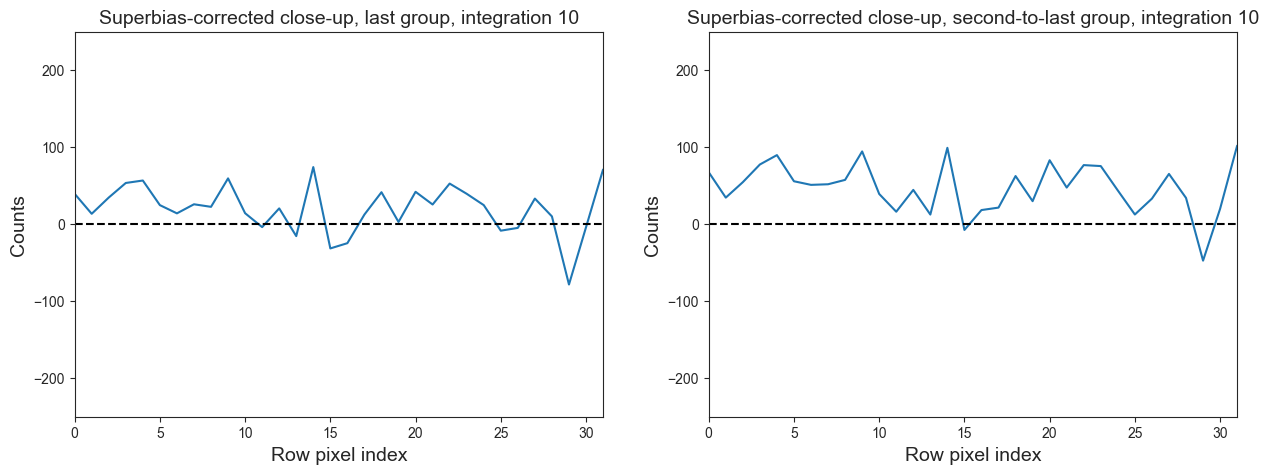

In [99]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(superbias_results.data[0,-1,:,250])
ax[0].plot([0, 32], [0, 0], 'k--')
ax[0].set_xlabel('Row pixel index', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_title('Superbias-corrected close-up, last group, integration 10', fontsize = 14)
ax[0].set_ylim(-250,250)
ax[0].set_xlim(0,31)

ax[1].set_title('Superbias-corrected close-up, second-to-last group, integration 10', fontsize = 14)
ax[1].plot(superbias_results.data[0,-2,:,250])
ax[1].plot([0, 32], [0, 0], 'k--')
ax[1].set_ylim(-250,250)
ax[1].set_xlim(0,31)
ax[1].set_xlabel('Row pixel index', fontsize = 14)
ax[1].set_ylabel('Counts', fontsize = 14)

Note how the pedestal correction the `superbias` step has, first of all, **not** brought the background down to zero. One might suggest that some from of scattered light could have, perhaps, made it to this non-iluminated part of the detector. However, puzzlingly enough, the second-to-last group appears to have _larger_ overall counts than the last group --- while intuitively, for up-the-ramp samples, it should be the other way around.

The answer to this puzzling behavior is that there are other, group-dependant detector effects that need to be removed. These are the ones the so-called "reference pixels" in the detector aim at correcting for, which is done in the JWST Calibration pipeline via the `refpix` step --- the step we cover next in this Notebook.

#### 3.3.2 Removing group-dependant detector effects: the `refpix` step

All the JWST detectors contain reference pixels, typically located in some (or all) of the edges of the detectors. These pixels are ones for which their "sensitivity to light" has been deactivated, and are thus useful for tracking detector-level effects happening at the time of our observations. While all detectors have those, **not all detector subarrays** contain reference pixels. Some, like in our case, contain reference pixels only in certain portions of the subarray.

Let's visualize where those reference pixels are in our subarray by using the `pixeldq` flags:

In [101]:
# Create an array that will save locations of reference pixels:
reference_pixels = np.zeros([rows, columns])

# Iterate through every row and column:
for row in range(rows):
    
    for column in range(columns):

        # Extract the bad pixel flag(s) for the current pixel at (row, column):
        bps = datamodels.dqflags.dqflags_to_mnemonics(superbias_results.pixeldq[row, column], 
                                                      mnemonic_map = datamodels.dqflags.pixel)

        if 'REFERENCE_PIXEL' in bps:

            reference_pixels[row, column] = 1

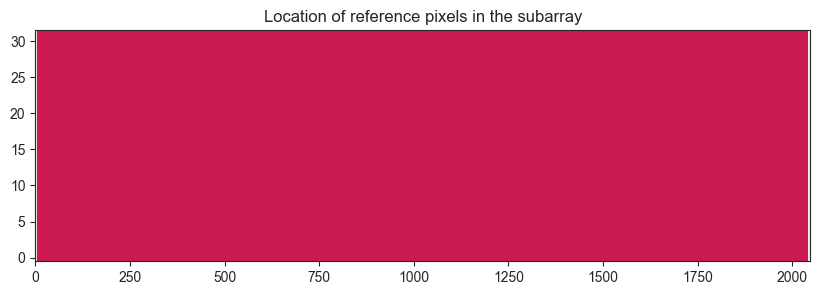

In [105]:
plt.figure(figsize=(10,3))

plt.title('Location of reference pixels in the subarray')
im = plt.imshow(reference_pixels, aspect = 'auto', origin = 'lower')
im.set_clim(-0.5,0.5)

Note the white edges to the left and the right of the plot above? That's the location of the reference pixels for our subarray. In other words, our subarray has reference pixels to the left and right-most sides, but not on the top or bottom part.

This is important to note because when one inspects NIRSpec/G395H data, there are clearly row-by-row effects and column-by-column effects. **The most important row-by-row effect is the so-called "odd/even" effect**, whose symptom is that of alternating flux "jumps" that is seen in all odd columns at one level, and at even columns at another level. To illustrate this, let's plot all the odd and even rows in our subarray for integration 10, last group:

(-50.0, 200.0)

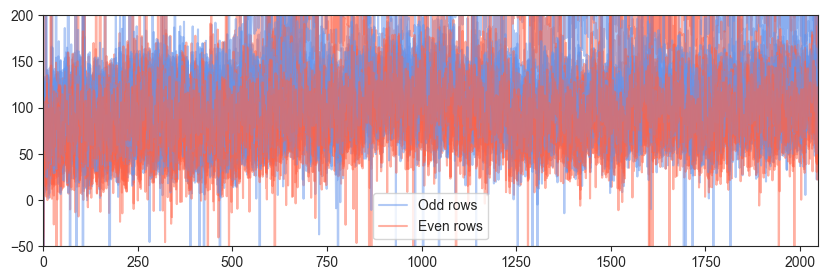

In [118]:
plt.figure(figsize=(10,3))

for i in range(32):

    if i < 2:

        if i % 2:

            name = 'Even rows'

        else:

            name = 'Odd rows'

    else:

        name = None

    if i % 2:

        plt.plot(superbias_results.data[10, -1, i, :], color = 'tomato', alpha = 0.5, label = name)

    else:

        plt.plot(superbias_results.data[10, -1, i, :], color = 'cornflowerblue', alpha = 0.5, label = name)

plt.legend()
plt.xlim(0, 2048)
plt.ylim(-50,200)

Note how the red and blue curves are all offset from one another due to this "odd/even" effect. On the other hand, **the most important "column-by-column" detector effect is 1/f noise**. A symptom of this effect is an apparent vertical "banding" on the detector, which will become very apparent once we apply the reference pixel correction. **There's a third important detector effect which offsets all pixels up and down throughout the detector on a group-level basis**. As can be seen, the row-by-row and this third, all-pixel offset should be corrected by the reference pixels at the edge of our subarray --- but the 1/f, column-by-column effect should remain.

Let's apply the `refpix` step to check how our data looks like after it:

In [121]:
refpix_results = calwebb_detector1.refpix_step.RefPixStep.call(superbias_results)

2023-11-27 01:26:08,295 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2023-11-27 01:26:08,448 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg003_nrs1_uncal.fits>,).
2023-11-27 01:26:08,449 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True, 'ovr_corr_mitigation_ftr': 3.0}
2023-11-27 01:26:12,028 - stpipe.RefPixStep - INFO - NIR subarray data
2023-11-27 01:26:12,034 - stpipe.RefPixStep - INFO - Single readout amplifier used
2023-11-27 01:26:12,034 - stpipe.RefPixStep - INFO - The following parameter is valid for this

Let's plot once again the figures above. First, a vertical cut of the profile at pixel column index 250:

Text(0, 0.5, 'Counts')

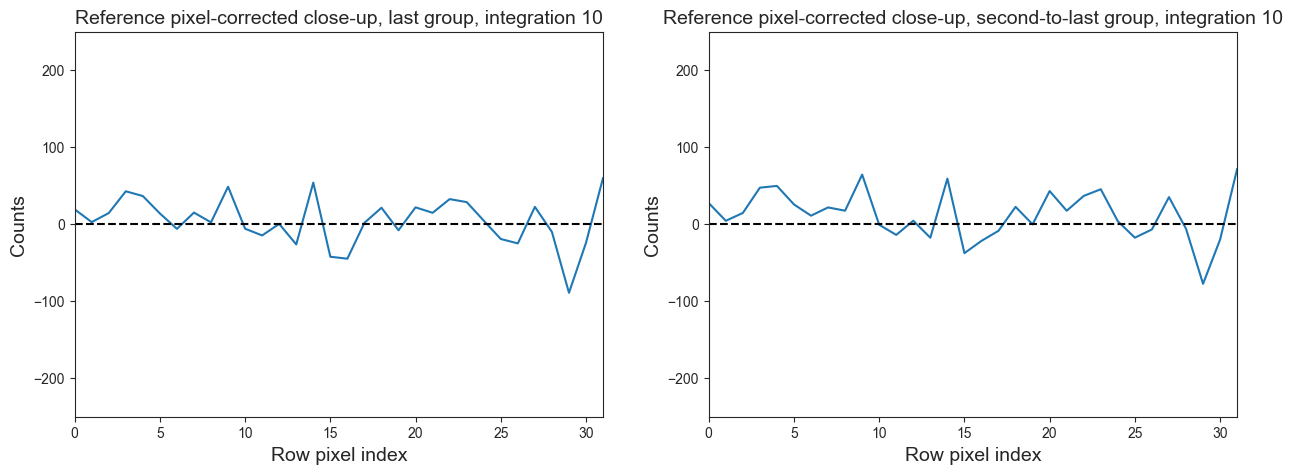

In [123]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(refpix_results.data[0,-1,:,250])
ax[0].plot([0, 32], [0, 0], 'k--')
ax[0].set_xlabel('Row pixel index', fontsize = 14)
ax[0].set_ylabel('Counts', fontsize = 14)
ax[0].set_title('Reference pixel-corrected close-up, last group, integration 10', fontsize = 14)
ax[0].set_ylim(-250,250)
ax[0].set_xlim(0,31)

ax[1].set_title('Reference pixel-corrected close-up, second-to-last group, integration 10', fontsize = 14)
ax[1].plot(refpix_results.data[0,-2,:,250])
ax[1].plot([0, 32], [0, 0], 'k--')
ax[1].set_ylim(-250,250)
ax[1].set_xlim(0,31)
ax[1].set_xlabel('Row pixel index', fontsize = 14)
ax[1].set_ylabel('Counts', fontsize = 14)

Nice, now flux is down to the zero-level. What about the odd-even effect?

(-50.0, 200.0)

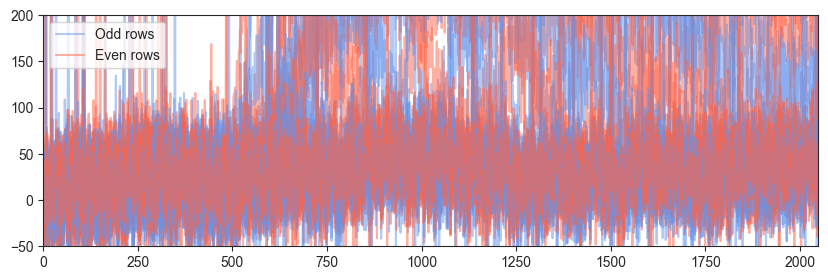

In [124]:
plt.figure(figsize=(10,3))

for i in range(32):

    if i < 2:

        if i % 2:

            name = 'Even rows'

        else:

            name = 'Odd rows'

    else:

        name = None

    if i % 2:

        plt.plot(refpix_results.data[10, -1, i, :], color = 'tomato', alpha = 0.5, label = name)

    else:

        plt.plot(refpix_results.data[10, -1, i, :], color = 'cornflowerblue', alpha = 0.5, label = name)

plt.legend()
plt.xlim(0, 2048)
plt.ylim(-50,200)

Gone, too!

Let's plot the 2D frame of this integration to see how the data looks like:

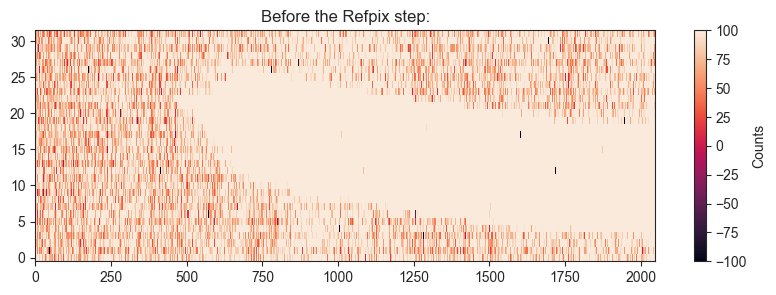

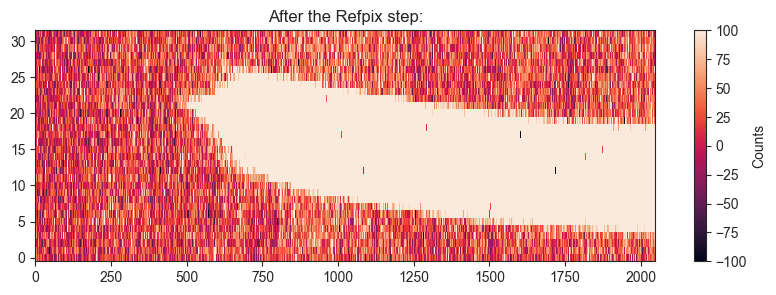

In [126]:
# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(superbias_results.data[10,-1,:,:],\
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-100,100)
plt.title('Before the Refpix step:')

plt.colorbar(label = 'Counts')

# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(refpix_results.data[10,-1,:,:],\
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-100,100)
plt.title('After the Refpix step:')
plt.colorbar(label = 'Counts')

Wow! That looks much better. Note how most of the structure has been removed, as well as the overall offset of the groups, which are now nicely centered around 0. 

It is interesting to note that the "banding" on the columns, as discussed above, has not dissapeared. This is more evident when plotting a series of groups from different integrations; let's plots the groups from integrations 10, 11 and 12:

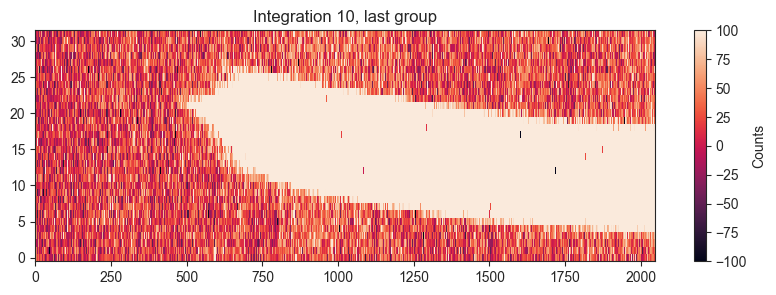

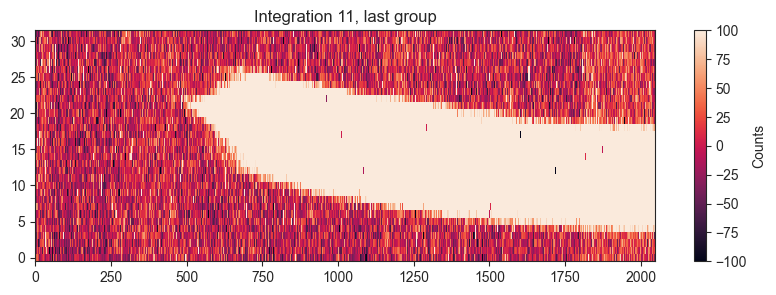

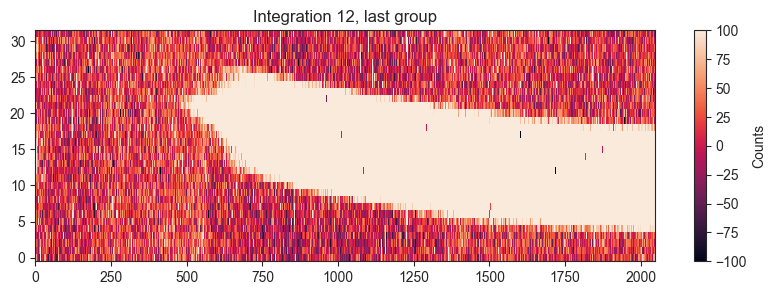

In [131]:
# Integration 10, last group
plt.figure(figsize=(10,3))
plt.title('Integration 10, last group')
im = plt.imshow(refpix_results.data[10,-1,:,:],\
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-100,100)
plt.colorbar(label = 'Counts')

# Integration 10, last group
plt.figure(figsize=(10,3))
plt.title('Integration 11, last group')
im = plt.imshow(refpix_results.data[11,-1,:,:],\
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-100,100)
plt.colorbar(label = 'Counts')

# Integration 12, last group
plt.figure(figsize=(10,3))
plt.title('Integration 12, last group')
im = plt.imshow(refpix_results.data[12,-1,:,:],\
                aspect = 'auto', origin = 'lower', interpolation = 'None')
im.set_clim(-100,100)
plt.colorbar(label = 'Counts')

This is, once again, expected as there are no reference pixels in the columns. We will explore how to correct this after going with the `linearity` correction/step, which we discuss next. Before moving on, we apply the superbias and reference pixel step to both detectors, all segments:

In [132]:
nsegments = 3
for i in range(nsegments):

    # Apply superbias and refpix to NRS1:
    uncal_nrs1[i] = calwebb_detector1.superbias_step.SuperBiasStep.call(uncal_nrs1[i])
    uncal_nrs1[i] = calwebb_detector1.refpix_step.RefPixStep.call(uncal_nrs1[i])
    
    # Apply superbias and refpix to NRS2:
    uncal_nrs2[i] = calwebb_detector1.superbias_step.SuperBiasStep.call(uncal_nrs2[i])
    uncal_nrs2[i] = calwebb_detector1.refpix_step.RefPixStep.call(uncal_nrs2[i])

2023-11-27 12:23:53,253 - stpipe.SuperBiasStep - INFO - SuperBiasStep instance created.
2023-11-27 12:23:53,630 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-11-27 12:23:53,631 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-11-27 12:23:53,647 - stpipe.SuperBiasStep - INFO - Using SUPERBIAS reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0427.fits
2023-11-27 12:24:06,911 - stpipe.SuperBiasStep - INFO - Results used CRDS context: jwst_1149.pmap
2023-11-27 12:24:06,914 - stpipe.SuperBiasStep - INFO - Step SuperBiasStep done
2023-11-27 12:24:07,051 - stpipe.RefPixStep - IN

### 3.3<font color='white'>-</font>Linearity corrections <a class="anchor" id="linearity"></a>

As a pixel accumulates charge, it becomes less and less efficient at generating charge-carriers and/or holding that charge in place. A consequence of this is that the raw -uncalibrated- up-the-ramp samples in JWST detectors are non-linear, with the pixels at lower fluences being almost linear and pixels near the saturation ranges deviating significantly from this behavior. This is the behavior that the `linearity` step in the JWST Calibration pipeline aims to fix.

#### 3.3.1 Visualizing and correcting for non-linearity with the `linearity` step

To visualize the non-linearity of the up-the-ramp samples, let's take a look at the samples of one of the brightest pixels in our subarray, pixel `(12, 2000)` --- say for integration number 10. Let's plot on top a line fitted to the first 10 pixels, which should be the most "linear" of all pixels:

(0.5, 70.5)

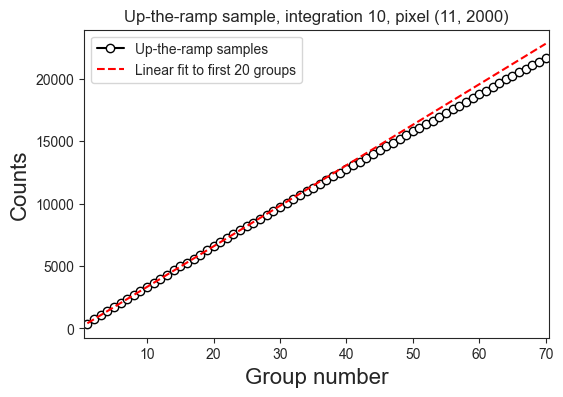

In [175]:
ngroups = uncal_nrs1[0].data.shape[1]
group = np.arange(ngroups) + 1

first_groups = 20

coeff = np.polyfit(group[:first_groups],  uncal_nrs1[0].data[10, :first_groups, 11, 2000], 1)

plt.figure(figsize=(6,4))

plt.title('Up-the-ramp sample, integration 10, pixel (11, 2000)')

plt.plot( group, uncal_nrs1[0].data[10, :, 11, 2000], 'o-', color = 'black', mfc = 'white', label = 'Up-the-ramp samples')
plt.plot( group, np.polyval(coeff, group), 'r--', label = 'Linear fit to first '+str(first_groups)+' groups')

plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.legend()
plt.xlim(0.5, 70.5)

Ah --- the ramp is _clearly_ non-linear! Let's apply the `linearity` step to the very first segment of NRS1 to see how well this gets corrected:

In [169]:
# Run linearity step:
linearity_results = calwebb_detector1.linearity_step.LinearityStep.call(uncal_nrs1[0])

2023-11-27 14:00:11,984 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2023-11-27 14:00:12,235 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-11-27 14:00:12,236 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-11-27 14:00:12,252 - CRDS - INFO -  Fetching  $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits   14.9 M bytes  (1 / 1 files) (0 / 14.9 M bytes)
2023-11-27 14:00:16,045 - stpipe.LinearityStep - INFO - Using Linearity reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits
2023-11-27 14:00:16,083 - stpipe.LinearityStep - WAR

Let's try the same plot as above, but with the linearity-corrected data:

(0.5, 70.5)

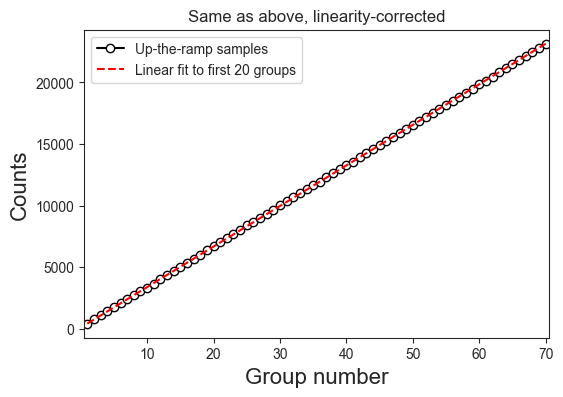

In [174]:
ngroups = uncal_nrs1[0].data.shape[1]
group = np.arange(ngroups) + 1

first_groups = 20

coeff = np.polyfit(group[:first_groups],  linearity_results.data[10, :first_groups, 11, 2000], 1)

plt.figure(figsize=(6,4))

plt.title('Same as above, linearity-corrected')

plt.plot( group, linearity_results.data[10, :, 11, 2000], 'o-', color = 'black', mfc = 'white', label = 'Up-the-ramp samples')
plt.plot( group, np.polyval(coeff, group), 'r--', label = 'Linear fit to first '+str(first_groups)+' groups')

plt.xlabel('Group number', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.legend()
plt.xlim(0.5, 70.5)

Ah, much better! 

#### 3.3.2 Testing the accuracy of the `linearity` step

It is important to realize that the linearity corrections that the JWST Calibration pipeline applies through the `linearity` step are _not_ perfect. While this is difficult to see with a single integration, this can be studied with multiple integrations --- which helps us beat the noise embedded on single up-the-ramp samples. 

One trick to glance at how the linearity of the up-the-ramp samples evolves as one goes up-the-ramp is to note that if the detector is linear, it doesn't matter at which up-the-ramp sample one looks at, the **fluence level should change from group-to-group at _the same rate_ on average**. So one can quickly investigate if linearity is an issue (and if the pipeline is correctly correcting for it) by:

1. Taking the difference in fluence between two subsequent groups (say, the last two).
2. Taking the difference in fluence between two _other_ subsequent groups (say, the first two).
3. Take the ratio between those differences.

If the detector is linear, then all the pixels should fall around a ratio of 1. Do they? Let's try this experiment out. Let's first take the difference of the last two and first two groups for all the pixels of all the integrations of the **uncorrected** data --- then take the ratio of those. As we saw above, this should scream "non-linearity" all over!

In [188]:
last_pair = uncal_nrs1[0].data[:, -1, :, :] - uncal_nrs1[0].data[:, -2, :, :]
first_pair = uncal_nrs1[0].data[:, 1, :, :] - uncal_nrs1[0].data[:, 0, :, :]

In [189]:
ratio = last_pair / first_pair

2023-11-27 16:33:57,099 - stpipe - WARNING - /var/folders/y5/_ldk3z5d46qf_8jkyqk5trbw0002dd/T/ipykernel_33578/940140270.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio = last_pair / first_pair



Let's now flatten those arrays and plot them as a function of total fluence at the very last group. If linearity weren't an issue, all of these should line around 1:

In [190]:
flattened_ratio = ratio.flatten()
flattened_fluences = uncal_nrs1[0].data[:, -1, :, :].flatten()

Text(0.5, 1.0, 'No linearity correction')

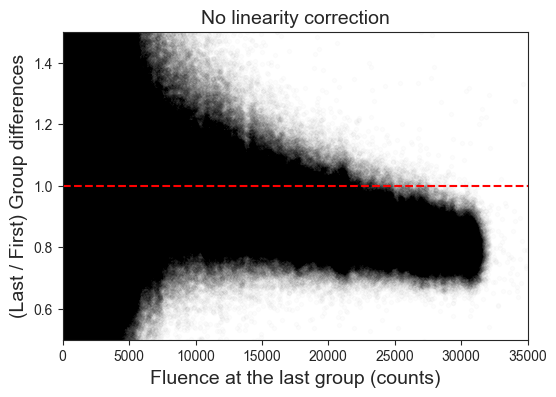

In [203]:
plt.figure(figsize = (6,4))
plt.plot(flattened_fluences, flattened_ratio, '.', alpha = 0.01, color = 'black')
plt.plot([0,35000], [1., 1.], 'r--')
plt.ylim(0.5,1.5)
plt.xlim(0,35000)
plt.xlabel('Fluence at the last group (counts)', fontsize = 14)
plt.ylabel('(Last / First) Group differences', fontsize = 14)
plt.title('No linearity correction', fontsize = 14)

Indeed, the data does _not_ line up around 1. So linearity _is_ an issue (as we already observed in the up-the ramp samples before)!

All right, let's try the same experiment but now on the linearity-corrected data:

In [192]:
corrected_last_pair = linearity_results.data[:, -1, :, :] - linearity_results.data[:, -2, :, :]
corrected_first_pair = linearity_results.data[:, 1, :, :] - linearity_results.data[:, 0, :, :]
corrected_ratio = corrected_last_pair / corrected_first_pair

2023-11-27 16:34:46,390 - stpipe - WARNING - /var/folders/y5/_ldk3z5d46qf_8jkyqk5trbw0002dd/T/ipykernel_33578/2478077767.py:3: RuntimeWarning: divide by zero encountered in divide
  corrected_ratio = corrected_last_pair / corrected_first_pair

2023-11-27 16:34:46,391 - stpipe - WARNING - /var/folders/y5/_ldk3z5d46qf_8jkyqk5trbw0002dd/T/ipykernel_33578/2478077767.py:3: RuntimeWarning: invalid value encountered in divide
  corrected_ratio = corrected_last_pair / corrected_first_pair



Let's plot:

In [193]:
flattened_corrected_ratio = corrected_ratio.flatten()
flattened_corrected_fluences = linearity_results.data[:, -1, :, :].flatten()

Text(0.5, 1.0, 'After linearity correction')

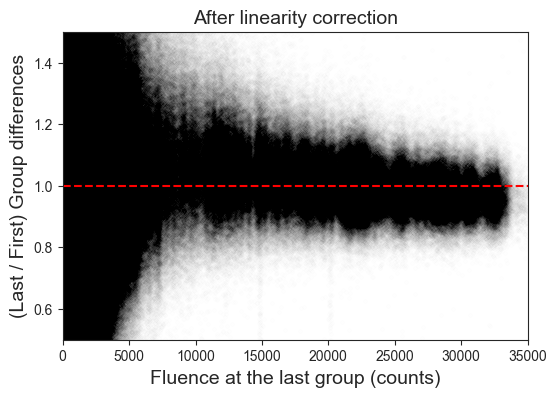

In [204]:
plt.figure(figsize = (6,4))
plt.plot(flattened_corrected_fluences, flattened_corrected_ratio, '.', alpha = 0.005, color = 'black')
plt.plot([0,35000], [1., 1.], 'r--')
plt.ylim(0.5,1.5)
plt.xlim(0,35000)
plt.xlabel('Fluence at the last group (counts)', fontsize = 14)
plt.ylabel('(Last / First) Group differences', fontsize = 14)
plt.title('After linearity correction', fontsize = 14)

That looks **much** better. Note, however, that as discussed above the corrections are *not* perfect. In particular, below about 20,000 counts it seems the correction makes the last group difference to be slightly larger than the first group differences; this changes for the larger fluences, where the last group difference seems to have a _smaller_ flux than the first group differences. This is actually consistent with a _charge migration_ hypothesis, on which pixels that receive larger fluences _lose_ charge to neighboring pixels that receive them. Testing this hypothesis is, of course, outside of the present Notebook --- but this showcases that plots like the ones above are fundamental to make sense of data and the overall accuracy and precision of non-linearity corrections.

Before moving to the next step, we apply the `linearity` step to all our data:

In [205]:
nsegments = 3
for i in range(nsegments):

    # Apply the linearity step to NRS1:
    uncal_nrs1[i] = calwebb_detector1.linearity_step.LinearityStep.call(uncal_nrs1[i])
    
    # Same, for NRS2:
    uncal_nrs2[i] = calwebb_detector1.linearity_step.LinearityStep.call(uncal_nrs2[i])

2023-11-27 17:06:28,221 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2023-11-27 17:06:28,675 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-11-27 17:06:28,676 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2023-11-27 17:06:28,692 - stpipe.LinearityStep - INFO - Using Linearity reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits
2023-11-27 17:06:28,747 - stpipe.LinearityStep - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored
2023-11-27 17:06:41,790 - stpipe.LinearityStep - INFO - Results used CRDS conte

### 3.4<font color='white'>-</font>Handling 1/f noise <a class="anchor" id="1overf"></a>

One of the last steps before the most computationally expensive steps in the pipeline is the `dark_current` step. This step grabs a reference file that calculates the dark current at each group, and applies the same correction to every integration in the same way. 

It is unclear if this step is helpful at all for TSOs, where signals are typically high, but we go ahead and apply this step nonetheless in our data. First, to check what changes this step does in our data, we apply it on the first NRS1 segment: 

In [206]:
# Run the darkcurrent step:
darkcurrent_results = calwebb_detector1.dark_current_step.DarkCurrentStep.call(uncal_nrs1[0])

2023-11-27 17:17:16,804 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2023-11-27 17:17:17,073 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-11-27 17:17:17,074 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2023-11-27 17:17:17,091 - CRDS - INFO -  Fetching  $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0388.fits   64.8 M bytes  (1 / 1 files) (0 / 64.8 M bytes)
2023-11-27 17:17:20,691 - stpipe.DarkCurrentStep - INFO - Using DARK reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0388.fits
2023-11-27 17:17:20,758 - stpipe

Let's see its impact on products before the dark current correction:

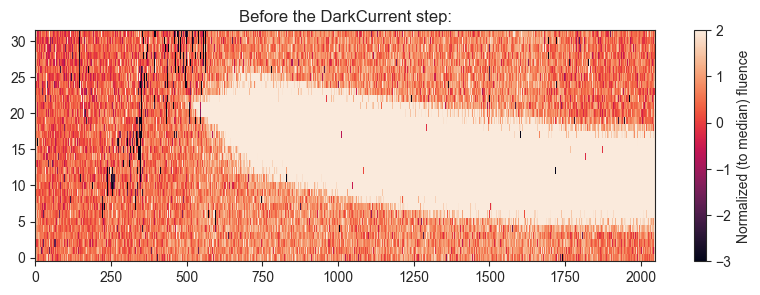

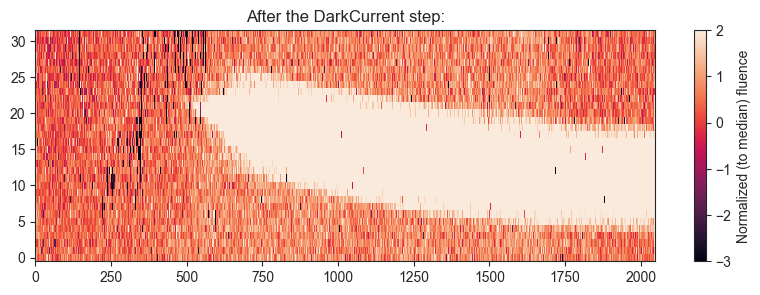

In [211]:
# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(uncal_nrs1[0].data[0,-1,:,:] / np.nanmedian(uncal_nrs1[0].data[0,-1,:,:]), \
                interpolation = 'None', aspect = 'auto', origin = 'lower')
im.set_clim(-3,2)
plt.colorbar(label = 'Normalized (to median) fluence')
plt.title('Before the DarkCurrent step:')

# Plot them:
plt.figure(figsize=(10,3))
im = plt.imshow(darkcurrent_results.data[0,-1,:,:] / np.nanmedian(darkcurrent_results.data[0,-1,:,:]), \
                interpolation = 'None', aspect = 'auto', origin = 'lower')

im.set_clim(-3,2)
plt.title('After the DarkCurrent step:')
plt.colorbar(label = 'Normalized (to median) fluence')

Not much, apparently. We apply it nonetheless to all the detector-level data of both NRS1 and NRS2, all segments:

In [212]:
nsegments = 3
for i in range(nsegments):

    # Apply the linearity step to NRS1:
    uncal_nrs1[i] = calwebb_detector1.dark_current_step.DarkCurrentStep.call(uncal_nrs1[i])
    
    # Same, for NRS2:
    uncal_nrs2[i] = calwebb_detector1.dark_current_step.DarkCurrentStep.call(uncal_nrs2[i])

2023-11-27 17:21:48,642 - stpipe.DarkCurrentStep - INFO - DarkCurrentStep instance created.
2023-11-27 17:21:48,876 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep running with args (<RampModel(155, 70, 32, 2048) from jw01366003001_04101_00001-seg001_nrs1_uncal.fits>,).
2023-11-27 17:21:48,877 - stpipe.DarkCurrentStep - INFO - Step DarkCurrentStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}
2023-11-27 17:21:48,893 - stpipe.DarkCurrentStep - INFO - Using DARK reference file $HOME/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0388.fits
2023-11-27 17:21:48,940 - stpipe.DarkCurrentStep - INFO - Science data nints=155, ngroups=70, nframes=1, groupgap=0
2023-11-27 17:21:48,941 - stpipe.DarkCurrentStep - INFO - Dark data nints=1, ngroups=

This step is the last in the near-infrared detectors that tries to remove any detector-level effects at the group-level, at least in the current version of the pipeline. However, some detector effects still remain --- in particular, the "infamous" 1/f noise. This is a type of noise that appears on every group independently, but it _can_ be buried below some cosmetic effects if we were to plot the groups after each other:

In [ ]:
for i in range(6):
    
    plt.figure(figsize=(20,5))
    im = plt.imshow(darkcurrent_results.data[0,i,:,:], interpolation = 'None')
    im.set_clim(-50,50)
    plt.title('First integration, group '+str(i+1))

Instead, and to see it more clearly, let's plot the differences between groups --- this should remove the signals which are common to each group, and only leave any residual noise in the background region. 

Let's plot the difference between groups 2 and 1, 3 and 2, and so on:

In [ ]:
for i in range(5):
    
    plt.figure(figsize=(20,5))
    im = plt.imshow(darkcurrent_results.data[0,i + 1,:,:] - darkcurrent_results.data[0,i,:,:], interpolation = 'None')
    im.set_clim(-50,50)
    plt.title('First integration, group '+str(i + 2)+' - group '+str(i+1))

See those vertical stripes? **That's the so-called "1/f noise"**. 

As you can see, this noise is not constant accross groups but, instead, each group samples a "realization" of it. The reason why it's called "1/f noise" is because what is seen as vertical stripes is, instead, a time-series that occurs _accross_ the pixels in each group (really, in each frame --- but in the case of the readout mode being used here, a frame _is_ a group). 

How this works is that, in reality, to read these up-the-ramp samples the detector uses some electronics that need to read each pixel's signal sequentially. It starts with the pixel in one of the corners, and then moves to the next pixel in the same column taking, in the case of this detector (and most currently supported modes for JWST detectors), 10 microseconds. Then, it jumps to the next in the same column in 10 microseconds, and so on. When it reaches the end of a column after jumping in this case through 256 pixels, the electronics are ordered to wait 120 microseconds exactly before moving to the next column. And then the process repeats. Here's a schematic showing a cartoon of this process:

![alt text](one-over-f.png "1/f noise schematic")

1/f noise in this context arises because the readout electronics have noise associated with it, and the power-spectral density (PSD) of this noise, if one "tags" each pixel with the clocking process described above, has a $1/f^{\beta}$ shape --- with the power index, $\beta$, very close to 1. 

We're currently hard at work at STScI characterizing this effect (and thinking/implementing possible ways of account for it), but one easy way of decreasing its impact, at least on white-light lightcurves and/or binned lightcurves is to perform simple column-to-column substraction of non-iluminated pixels. That is --- simply select all non-illuminated pixels in a column, take their mean/median, and remove it for that column. The simplest version of this idea is to just take the median value of each column --- this assumes the number of non-illuminated pixels is much larger than the illuminated ones:

In [ ]:
def correct_one_over_f(image):
    
    corrected_image = np.copy(image)
    for i in range(image.shape[1]):
        
        corrected_image[:, i] -= np.nanmedian(corrected_image[:,i])
        
    return corrected_image      

Let's try it out on the group differences above:

In [ ]:
for i in range(5):
    
    plt.figure(figsize=(20,5))
    im = plt.imshow(correct_one_over_f(darkcurrent_results.data[0,i + 1,:,:] - darkcurrent_results.data[0,i,:,:]), 
                    interpolation = 'None')
    im.set_clim(-50,50)
    plt.title('First integration, group '+str(i + 1)+' - group '+str(i) + ' (1/f corrected)')

This looks **much better, doesn't it**? It is important, however, to not let your eye trick you: this method only partially corrects 1/f noise. In particular, our experiments show it's useful for lowering the impact of this noise at time/length-scales of order $\sim 10$ columns long or larger only. This means that 1/f-like residual noise is _still_ present in these groups at time/length-scales smaller than that. 

You can check the level of residual 1/f noise directly on your own TSO products by assigning time-stamps to each pixel, and computing the PSD of the resulting time-series either on a given group or for a set of groups. To illustrate how to do this, let's get the PSD of the non-iluminated pixels on each column. Then, let's take the median of all the PSDs of all columns in order to get a representative PSD of the non-iluminated pixels on each column: 

In [ ]:
# Set some definitions for the power-spectral densities:
clock_between_pixels = 10 * 1e-6                    # 10 microseconds
min_frequency = 1. / (256 * clock_between_pixels)   # inverse clock-time of a column
max_frequency = (1. / clock_between_pixels) * 0.5   # same for two pixels -- Nyquist frequency (hence x 0.5)

# Define the frequency array at which we'll compute the PSDs; set linspace because it's faster:
frequencies = np.linspace(min_frequency, max_frequency, 10000)

# Compute PSDs on a single group difference. First, correct it (to get same result as above):
corrected_difference = correct_one_over_f(darkcurrent_results.data[0, 1, :, :] - darkcurrent_results.data[0, 0, :, :])

# Define time-stamps for each pixel in a column:
times = np.arange(256) * clock_between_pixels

# Now iterate through columns, generating the PSD at each column:
psds = []
for i in range(2048):
    
     # First, compute median-absolute deviation of the column flux:
     column_flux = corrected_difference[:, i]
     sigma_mad = 1.48 * np.nanmedian( np.abs( column_flux - np.nanmedian(column_flux) ) )
     
     # Now, identify all values within 10-sigma from zero --- which will be the un-illuminated pixels:
     idx = np.where(np.abs(column_flux) < sigma_mad)
    
     # Compute the PSD of those pixels:
     psds.append(LombScargle(times[idx], column_flux[idx], normalization = 'psd').power(frequencies))
        
# Compute median PSDs of all columns:
psd = np.median( np.array(psds), axis = 0)

Now let's plot this PSD:

In [ ]:
fig, ax = plt.subplots(figsize = (10,6))

# plot PSD in log-space:
ax.plot(frequencies, psd)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(400, 40000)
ax.set_ylim(20,4e2)

# Define properties to define upper axis as well:
f = lambda x: ( 1. / x ) / (10 * 1e-6) 
g = lambda x: ( 1. / x ) / (10 * 1e-6)

ax2 = ax.secondary_xaxis("top", functions=(f, g))
ax2.tick_params(axis='both', which='major', labelsize=13)
ax2.set_xlabel("Pixel length-scale", fontsize = 14)

# Properties of bottom axis:
ax.set_title('PSD of column background\n', fontsize = 16)
ax.set_xlabel('Frequency (Hz)', fontsize = 14)
ax.set_ylabel('PSD', fontsize = 14)
ax.tick_params(axis='both', which='major', labelsize=13)

This _definitely_ doesn't look like white-noise (which would be a horizontal line on this plot). Instead, it goes up at lower frequencies with a $1/f$ shape --- hence the name of the effect. 

It is important to realize that 1/f noise is a stochastic process and, thus, it can't really be completely "corrected". It can, however, be accounted for in the modelling/spectral extraction in order to account for its known properties. As can be seen from the plot above as well, the smaller the ammount of pixels one considers, the more "white" the noise appears to be. For example, it is clear that if one only looks at lengthscales smaller than about 10 pixels, then the underlying noise is mostly white. This means that the smaller the aperture used to extract the spectra, the lower the impact of 1/f noise. A corollary of this is that it also means that the smaller the subarray (and/or the spectral profile), the better for 1/f noise as the noise will look mostly white. 

At the end of the day, it might be that certain apertures will be sweetspots for different datasets. As such, plots like the ones made here are very helfpul to identify how well a given correction for the effect is working and/or to identify limits/properties useful for including in the modelling efforts.

## 3.5 The "jump" detection

The next step on the pipeline is the "jump" step. What this step tries to detect are "jumps" due to cosmic-ray hits in the detector in the up-the-ramp samples. Let's apply it and see its effect on the data directly:

In [ ]:
# JWST pipeline outputs are typically of the form initialfile_YourStep.fits. 
# Check if jump-step has been already ran:
jump_output_filename = data_folder + filename.split('uncal.fits')[0] + 'jumpstep.fits'

# If it has, load it. If it hasn't, run it:
if os.path.exists(jump_output_filename):
    
    print('Jump detection already pre-computed; loading it:')
    jump_results = datamodels.open(jump_output_filename)
    print('...done!')

else:

    jump_results = calwebb_detector1.jump_step.JumpStep.call(darkcurrent_results, 
                                                         output_dir=pipeline_outputs_folder, 
                                                         save_results=True)

The position of the detected jumps are identified in the `group_dq` --- any value of 4 means a jump was detected. Let's explore how many of those where detected in the first integration and where:

In [ ]:
first_integration_jumps = np.where(jump_results.groupdq[0, :, :, :] == 4)

In [ ]:
print(len(first_integration_jumps[0]), 'pixels with JUMP_DET flag.')

Wow, that's a lot of jumps. Let's see _where_ they are located:

In [ ]:
# Define location of the jumps:
zero_array = np.zeros( [jump_results.groupdq.shape[2], jump_results.groupdq.shape[3]] )
zero_array[first_integration_jumps[1], first_integration_jumps[2]] = 1.

# Plot:
plt.figure(figsize=(20,5))
im = plt.imshow(zero_array, interpolation = None)

Interesting! It is clear the jump detection is, by default, too aggressive: the detected jumps are clearly located in particular regions of the detector. In particular, it is evident the step is detecting outliers following the 1/f banding we observed in the previous subsection. This makes sense with the algorithm the jump detection step uses to detect jumps, which is a two-point difference method, in which [group differences are used to detect jumps](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/description.html). Since our group differences are plagged with 1/f noise, then that will impact the jump detection too, which only assumes white read noise and poisson noise.

There are many ways to deal with this, but the most straightfoward is to simply increase the [threshold for jump detections](https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/arguments.html). The threshold to define a jump can be easily defined in the pipeline via the `rejection_threshold` parameter --- this is the "number of sigma" to call a detection. By default that is 4; let's set it to 10 and try again:

In [ ]:
jump_output_filename10 = data_folder + filename.split('uncal.fits')[0] + 'threshold_10.fits'

# If it has, load it. If it hasn't, run it:
if os.path.exists(jump_output_filename10):
    
    print('Jump detection already pre-computed; loading it:')
    jump_results10 = datamodels.open(jump_output_filename10)
    print('...done!')

else:

    # Run jump-detection step:
    jump_results10 = calwebb_detector1.jump_step.JumpStep.call(darkcurrent_results, 
                                                               output_dir=pipeline_outputs_folder, 
                                                               name = 'threshold_10',
                                                               rejection_threshold = 10,
                                                               save_results=True)      

In [ ]:
first_integration_jumps = np.where(jump_results10.groupdq[0, :, :, :] == 4)
print(len(first_integration_jumps[0]), 'pixels with JUMP_DET flag.')

In [ ]:
# Define location of the jumps:
zero_array = np.zeros( [jump_results10.groupdq.shape[2], jump_results10.groupdq.shape[3]] )
zero_array[first_integration_jumps[1], first_integration_jumps[2]] = 1.

# Plot:
plt.figure(figsize=(20,5))
im = plt.imshow(zero_array, interpolation = None)

That seems much better! And number of detected jumps has decreased by ~1/3 --- it reaches now about ~3% of pixels. This might not be perfect, and we might want to try a couple of runs of the pipeline end-to-end with different thresholds before deciding on a final one.

**It is important to note that when actual data comes, this parameter might be one of the most important to play with**. While the algorithm has been tested with simulated data, the final test will come with on-sky data. This will be particularly important to pay attention to during the first few Cycles of JWST science observations: it is possible a single threshold won't be useful for _all_ datasets, and thus checking the results like above will be fundamental. This can have a direct impact on the final signal-to-noise ratio achieved by pipeline data products!

## 3.6 the `ramp-fitting` step

The last step of `detector1` is the `ramp_fit` step. This step does something that might _appear_ to be quite simple, but that in reality it's not as trivial as it seems to be: fit a line and get the associated uncertainties to the up-the-ramp samples. Let's go ahead and just do it:

In [ ]:
rampfitstep_output0 = data_folder + filename.split('uncal.fits')[0] + 'threshold_10_0_rampfitstep.fits'
rampfitstep_output1 = data_folder + filename.split('uncal.fits')[0] + 'threshold_10_1_rampfitstep.fits'

if os.path.exists(rampfitstep_output0) and os.path.exists(rampfitstep_output1):
    
    print('Ramp-fitting already pre-computed; loading it:')
    rampfitting_results0 = datamodels.open(rampfitstep_output0)
    rampfitting_results1 = datamodels.open(rampfitstep_output1)
    rampfitting_results = [rampfitting_results0, rampfitting_results1]
    print('Done!')
    
else:
    rampfitting_results = calwebb_detector1.ramp_fit_step.RampFitStep.call(jump_results10, 
                                                                           output_dir=pipeline_outputs_folder, 
                                                                           save_results=True)   

All right! Note the products of this step for TSO's is actually a list:

In [ ]:
print(len(rampfitting_results))

The data associated with the zeroth element of this list (`rampfitting_results[0].data`) has dimensions equal to the size of the frames (rows and columns). The first element (`rampfitting_results[1].data`), has three dimensions, the same as the zeroth but for each integration (we usually refer to this product as the `rateints` product --- i.e., the rates per integration):

In [ ]:
rampfitting_results[0].data.shape

In [ ]:
rampfitting_results[1].data.shape

These results correspond to the "rates" (i.e., the slope of the line-fits to the up-the-ramp samples). Let's plot the very first integration to see how the rates for that look like:

In [ ]:
plt.figure(figsize=(20,5))
im = plt.imshow(rampfitting_results[1].data[0,:,:])
im.set_clim(-3,3)

That looks OK! However, we still see the strong 1/f banding in these rateint products. What if we perform the simple column-to-column corrections we did at the group-level above, but directly on these `rateint` products?:

In [ ]:
corrected_rampfit_results = np.copy(rampfitting_results[1].data)
original_rampfit_results = np.copy(rampfitting_results[1].data)

for integration in range(corrected_rampfit_results.shape[0]):
    
    corrected_rampfit_results[integration, :, :] = correct_one_over_f( original_rampfit_results[integration, :, :] )


In [ ]:
plt.figure(figsize=(20,5))
im = plt.imshow(corrected_rampfit_results[0,:,:])
im.set_clim(-3,3)

This looks much nicer! However, we do see darker pixels between around columns 1250 and 1800 --- this means there was an overcorrection of the estimated background level. This might very well be the simplistic approach to correct for 1/f: a better approach would be to mask all illuminated pixels, instead of just using the median directly of all pixels in a column. We touch base on this once again on Section 5.2 below. For now, we work with these "1/f-corrected/reduced" products.

The plot, overall, seems to indicate (just as the PSD above) that the noise properties are mostly white indeed. Perhaps there is hint for a stronger _decrease_ of the expected behaviour at larger bins, but this is not too obvious. Overall, it seems our white-light data behaves quite nicely as expected, as our simulated data doesn't have any other effect added to it other than the transit event!

4.<font color='white'>-</font>Final words <a class="anchor" id="final-words"></a>
------------------

I would like to take the opportunity to thank the entire JWST team behind this notebook, that through testing (with actual detector data, through simulations, etc.) and discussions made this product possible. In particular, to the Time-Series Observations Working Group at STScI, especially to Mike Reagan, Stephan Birkmann, Nikolay Nikolov, Arpita Roy, Loïc Albert and Leonardo Ubeda among others. To the NIRCam IDT members, including Everett Schlawin, Jarron Leisenring, Thomas Greene and Thomas Beatty with which a ton of discussion has been ongoing on different topics touched upon here. To the ERS Transiting Exoplanet team who have provided several venues for discussion and community input. To the JWST team behind the pipeline and the mission itself, including and in no particular order Anton Koekemoer, Alicia Canipe, Jeff Valenti, Karl Gordon, Bryan Hilbert and Joseph Filippazzo. 